In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configuration pour les graphiques
%matplotlib inline
sns.set(style="whitegrid")
np.random.seed(42) # Pour la reproductibilité

# 1. Chargement du dataset

In [38]:
dataset = pd.read_csv('dataset.csv')
dataset

,sleep_hours,exercise_minutes,screen_time_hours,water_glasses,fast_food_per_week,healthy
0,6.7,0,11.3,3,5,0
1,6.6,69,9.5,2,8,0
2,5.9,55,10.4,4,4,0
3,8.2,123,5.6,7,0,1
4,8.9,69,10.0,3,5,0
...,...,...,...,...,...,...
295,5.6,37,13.2,4,4,0
296,8.9,99,6.3,7,3,1
297,7.8,153,3.0,8,3,1
298,9.7,63,9.6,4,7,0


# 2. Préparation X et y & Split Train/Test

On sépare les variables (features) de la cible (label) et on divise en 80% entraînement / 20% test.

In [39]:
# Séparation des features (X) et de la target (y)
X = dataset.drop('healthy', axis=1).values
y = dataset['healthy'].values.reshape(-1, 1) 

# Split 80% Train - 20% Test manuellement
m = X.shape[0]
split_index = int(m * 0.8)

X_train_raw = X[:split_index]
y_train = y[:split_index]

X_test_raw = X[split_index:]
y_test = y[split_index:]

# Vérification des dimensions sous forme de tableau
pd.DataFrame({
    'Train Shape': [X_train_raw.shape, y_train.shape],
    'Test Shape':  [X_test_raw.shape, y_test.shape]
}, index=['X', 'y'])

,Train Shape,Test Shape
X,"(240, 5)","(60, 5)"
y,"(240, 1)","(60, 1)"


# 3. Normalisation (Standardization)

On fait la normalisation pour que la descente de gradient converge vite. On sauvegarde mean et std pour le backend.

In [40]:
# Calcul de la moyenne et de l'écart-type sur le TRAIN set uniquement
mean = np.mean(X_train_raw, axis=0)
std = np.std(X_train_raw, axis=0)

# Application de la normalisation : (x - u) / s
X_train = (X_train_raw - mean) / std
X_test = (X_test_raw - mean) / std

# Aperçu des données normalisées (premières lignes)
pd.DataFrame(X_train, columns=dataset.columns[:-1]).head()

,sleep_hours,exercise_minutes,screen_time_hours,water_glasses,fast_food_per_week
0,-0.144501,-1.677168,1.421969,-0.782985,0.670682
1,-0.225720,-0.416437,0.684968,-1.165706,2.042531
2,-0.794249,-0.672238,1.053468,-0.400263,0.213399
3,1.073775,0.570222,-0.911868,0.747902,-1.615734
4,1.642304,-0.416437,0.889690,-0.782985,0.670682


# 4. Modèle de régression logistique 

fonction sigmoid:
        $a(z) = \frac{1}{1 + e^{-z}}$

In [41]:
# 1. Fonction Sigmoïde
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [42]:
# 2. Initialisation des paramètres W et b
def initialisation(X):
    n_features = X.shape[1]
    W = np.random.randn(n_features, 1) * 0.01 # Petites valeurs aléatoires
    b = np.zeros((1, 1)) # Bias initialisé à 0
    return W, b

In [43]:
# 3. Le Modèle (Forward Propagation) : Z = X.W + b
def modele(X, W, b):
    Z = np.dot(X, W) + b
    A = sigmoid(Z)
    return A

In [44]:
# 4. Fonction Coût (Log Loss)
def log_loss(y, A):
    m = len(y)
    epsilon = 1e-15 # Pour éviter log(0)
    loss = -1/m * np.sum(y * np.log(A + epsilon) + (1 - y) * np.log(1 - A + epsilon))
    return loss

In [45]:
# 5. Calcul des Gradients (Backward Propagation)
def gradients(X, A, y):
    m = len(y)
    dW = 1/m * np.dot(X.T, (A - y))
    db = 1/m * np.sum(A - y)
    return dW, db

In [46]:
# 6. Mise à jour des paramètres (Optimisation)
def optimisation(W, b, dW, db, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return W, b

# 5. Entraînement du modèle

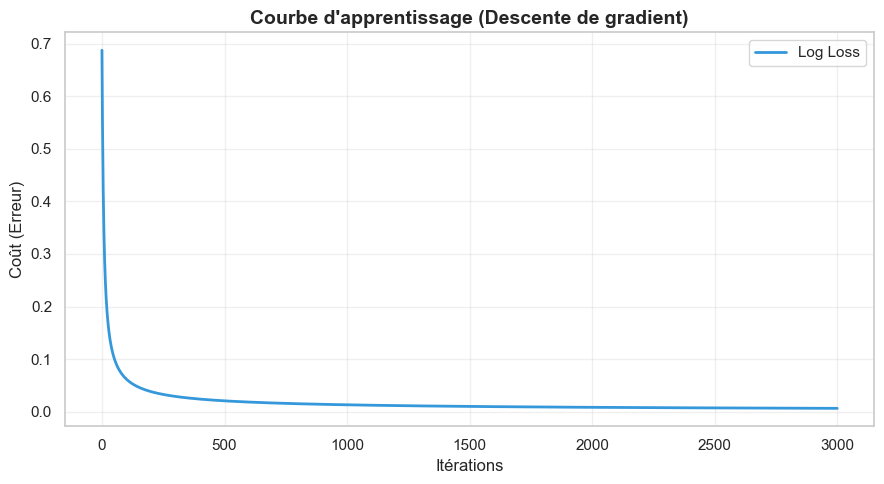


📊 Évolution de la Loss :
   • Loss initiale  : 0.6873
   • Loss finale    : 0.0065
   • Réduction      : 99.06%


In [47]:
def regression_logistique(X_train, y_train, learning_rate=0.1, n_iter=10000):
    """
    Entraîne un modèle de régression logistique from scratch
    
    Args:
        X_train: Données d'entraînement (n_samples, n_features)
        y_train: Labels d'entraînement (n_samples, 1)
        learning_rate: Taux d'apprentissage
        n_iter: Nombre d'itérations
    
    Returns:
        W: Poids finaux
        b: Biais final
        loss_history: Historique des erreurs
    """
    # Initialisation
    W, b = initialisation(X_train)
    loss_history = []
    
    # Boucle d'apprentissage
    for i in range(n_iter):
        # Forward - ✅ UTILISER X_train
        A = modele(X_train, W, b)
        
        # Loss - ✅ UTILISER y_train
        loss = log_loss(y_train, A)
        loss_history.append(loss)
        
        # Backward (Gradients)
        dW, db = gradients(X_train, A, y_train)
        
        # Update
        W, b = optimisation(W, b, dW, db, learning_rate)
        
    return W, b, loss_history

# Lancement de l'entraînement
W_final, b_final, loss_history = regression_logistique(
    X_train, y_train, 
    learning_rate=0.1, 
    n_iter=3000
)

# Visualisation de la courbe d'apprentissage
plt.figure(figsize=(9, 5))
plt.plot(loss_history, label='Log Loss', linewidth=2, color='#3498db')
plt.title('Courbe d\'apprentissage (Descente de gradient)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Itérations', fontsize=12)
plt.ylabel('Coût (Erreur)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Affichage des dernières valeurs de loss
print(f"\n📊 Évolution de la Loss :")
print(f"   • Loss initiale  : {loss_history[0]:.4f}")
print(f"   • Loss finale    : {loss_history[-1]:.4f}")
print(f"   • Réduction      : {(1 - loss_history[-1]/loss_history[0])*100:.2f}%")

# 6. Évaluation du modèle et visualisation

On teste le modèle sur les données de test (jamais vues).

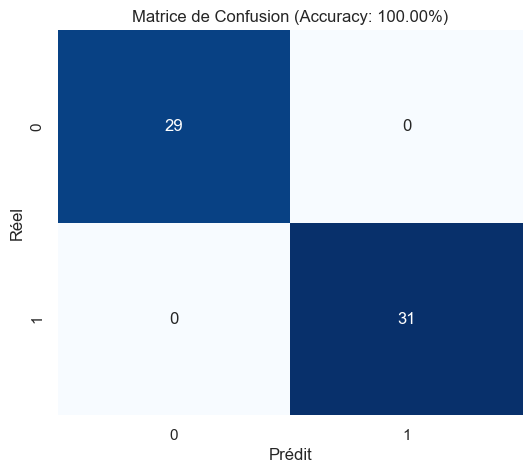

🎯 Accuracy sur le Test Set : 100.00%


In [52]:
# Fonction de prédiction sur le Test set
def predict(X, W, b):
    A = modele(X, W, b)
    return (A >= 0.5).astype(int)

# Prédiction sur le Test set
y_pred = predict(X_test, W_final, b_final)

# Calcul de l'Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Visualisation
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matrice de Confusion (Accuracy: {acc*100:.2f}%)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

print(f"🎯 Accuracy sur le Test Set : {acc*100:.2f}%")

# 8. Sauvegarde pour le Backend (model.json)

On exporte les paramètres du modèle pour l'application Web.

In [49]:
# Sauvegarde des paramètres et des stats de normalisation
model_data = {
    "w": W_final.flatten().tolist(), # Aplatir W en liste simple
    "b": float(b_final.item()),             # Convertir b en float
    "mean": mean.tolist(),
    "std": std.tolist()
}

with open('model.json', 'w') as f:
    json.dump(model_data, f, indent=4)

# Confirmation visuelle (sans print)
pd.DataFrame([model_data], index=['Paramètres exportés'])

,w,b,mean,std
Paramètres exportés,"[1.0799927482014893, 2.700601663171184, -1.949...",-0.575304,"[6.877916666666666, 91.79166666666667, 7.82708...","[1.2312476029305488, 54.730155586802006, 2.442..."
